In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
sales_of_company_x = pd.read_csv("../1. Знакомство с временными рядами/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../1. Знакомство с временными рядами/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../1. Знакомство с временными рядами/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../1. Знакомство с временными рядами/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../1. Знакомство с временными рядами/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../1. Знакомство с временными рядами/Series/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [4]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return result
    #return series.append(pd.Series(predictions), ignore_index=True)#, pd.Series(result)

def plot_ema(alpha, series, ser_to_plot,  n_preds=None):
    ema_preds = exponential_moving_average(series, alpha, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(ema_preds, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}".format(alpha))
        plt.legend()
        
def mse_ema_cross_val(X):
    alpha, _ = X
    split = TimeSeriesSplit(n_splits=2) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = exponential_moving_average(train_split_ts, alpha, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [5]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result)

def plot_dema(alpha, beta, series, ser_to_plot, n_preds=None):
    dema_preds = double_ema_with_preds(series, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(dema_preds, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

def mse_dema_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=2) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = double_ema_with_preds(train_split_ts, alpha, beta, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [6]:
def initial_trend(i, series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(i, series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

def mse_tema(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def mse_tema_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=2) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

International airline passengers: monthly totals in thousands
нестационарный ряд с ярковыреженным трендом и сезонностью
целесообразно использровать TEMA

In [7]:
series = all_series["International airline passengers: monthly totals in thousands"]
# series = all_series["Weekly closings of the Dow-Jones industrial average"]
len(series)

144

In [8]:
train, test = series[:120], series[120:]

In [9]:
# opt = minimize(mse_tema_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
opt = minimize(mse_tema_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

37387.09646508499------------
37387.07945786468------------
37387.09646508499------------
37387.09505711643------------
3805.739453125001------------
3805.7394713091053------------
3805.7361299139993------------
3805.739453125001------------
5392.171289588508------------
5392.171120897438------------
5392.171387320895------------
5392.171289588508------------
2044.4879228310676------------
2044.4878879552941------------
2044.4882009839114------------
2044.4879228310676------------
1909.8466419014292------------
1909.8466117547048------------
1909.8469044875299------------
1909.8466419014292------------
1477.889071167543------------
1477.8890582720605------------
1477.8892274917578------------
1477.889071167543------------
2188.135619721347------------
2188.135631008607------------
2188.134366075144------------
2188.135619721347------------
1371.0151656479015------------
1371.015160944081------------
1371.015196652645------------
1371.0151656479015------------
1369.1920450240455--------

In [10]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1368.3333168019003
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.43586908e+02, -1.59161573e-04,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 9
   status: 0
  success: True
        x: array([1.        , 0.02729484, 1.        ])


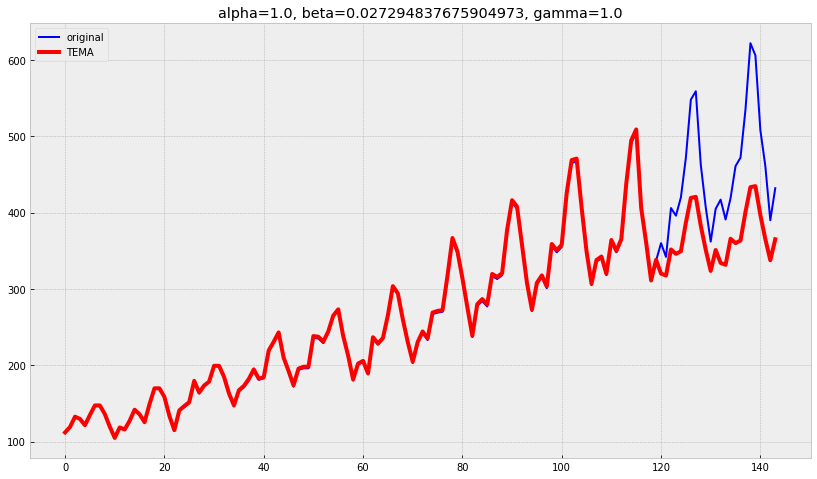

In [11]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

In [12]:
series = boxcox(series, 0)

In [13]:
series = np.diff(series, 1)

In [14]:
train, test = pd.Series(series[:120]), pd.Series(series[120:])

In [15]:
opt = minimize(mse_tema_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

0.006231191222185795------------
0.006231187192307375------------
0.006231191222185784------------
0.0062311908898692895------------
0.0020757411057423557------------
0.0020757411078311753------------
0.002075740825306531------------
0.0020757411039393743------------
0.001967026874080223------------
0.0019670268746488874------------
0.0019670268732293467------------
0.00196702687172924------------
0.001966961341271098------------
0.0019669613418368892------------
0.001966961340410524------------
0.00196696133891685------------
0.0019666977906750843------------
0.0019666977912299764------------
0.001966697789777325------------
0.0019666977883079405------------
0.001965622576173288------------
0.0019656225766941067------------
0.0019656225751546715------------
0.0019656225737571535------------
0.001961106775232221------------
0.001961106775766326------------
0.001961106774232377------------
0.001961106772659425------------
0.0019454560582308823------------
0.00194545606057854------------

In [16]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.0018945160826501122
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.08283608e-06, 1.75436922e-06, 4.24660307e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 104
      nit: 13
   status: 0
  success: True
        x: array([0.3637637 , 0.01382989, 0.34480774])


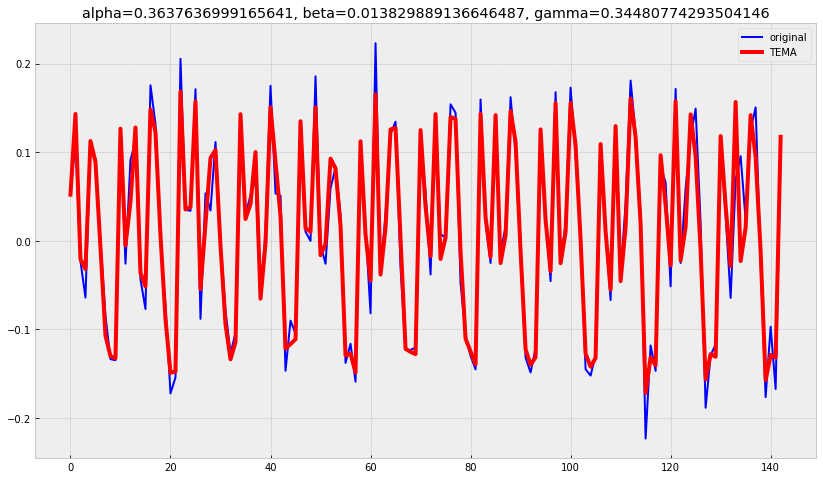

In [17]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

Mean monthly air temperature (Deg. F) Nottingham Castle
ряд является стационарным. у него нет тренда, но есть определенная цикличность
поэтому сначала пробуем приблизится через EMA

In [18]:
series = all_series["Mean monthly air temperature (Deg. F) Nottingham Castle"]
len(series)

240

In [19]:
train, test = series[:200], series[200:]

In [20]:
opt = minimize(mse_ema_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

149.780303030303------------
149.78016326582377------------
149.780303030303------------
225.56212121212124------------
225.5621202753333------------
225.56212121212124------------
129.5996478211879------------
129.5996512308979------------
129.5996478211879------------
126.95174660710114------------
126.95174996231685------------
126.95174660710114------------
116.85981273594564------------
116.85981581179351------------
116.85981273594564------------
88.3729534666804------------
88.3729548745203------------
88.3729534666804------------
79.5971748364677------------
79.59717510707851------------
79.5971748364677------------
80.83312910961425------------
80.83312622425586------------
80.83312910961425------------
79.4087947915209------------
79.40879488909296------------
79.4087947915209------------
79.41633696616194------------
79.4163368077518------------
79.41633696616194------------
79.39584986159684------------
79.39584986616332------------
79.39584986159684------------
79.39582797

In [21]:
alpha_opt, _ = opt.x
print(opt)

      fun: 79.39582713970842
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.52651283e-06, 0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 8
   status: 0
  success: True
        x: array([0.03681688, 0.        ])


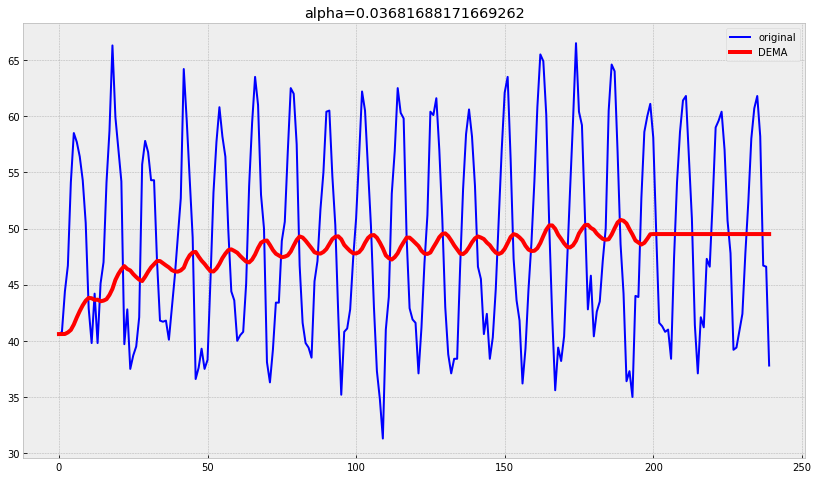

In [22]:
plot_ema(alpha_opt, series=train, ser_to_plot=series, n_preds=len(test))

EMA дает очень большую ошибку. поэтому надо использовать что-то другое
DEMA не подходит, т.к. у нас нет трендовой составляющей
попробуем TEMA, ожидая, что трендовая составляющая будет минимальной

In [23]:
opt = minimize(mse_tema_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 0.1), (0, 1)))

31.972130475207976------------
31.972063993755533------------
31.972130475207976------------
31.972124924089634------------
15.585775798271966------------
15.585775740594169------------
15.585790051454886------------
15.585775798271966------------


In [24]:
alpha_opt, betta_opt, gamma_opt = opt.x
print(opt)

      fun: 15.585775798271966
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -5.76777968, 1425.31829201,    0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([1., 0., 1.])


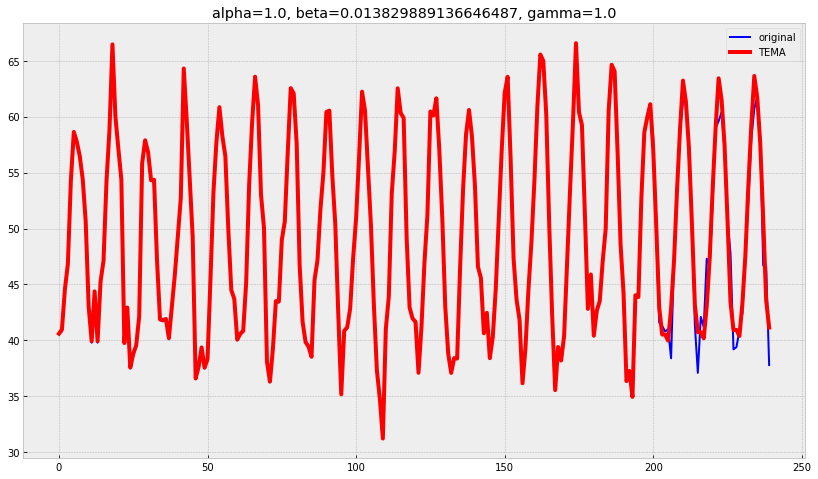

In [25]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))